In [169]:
%load_ext autoreload
%autoreload 2

import mcfost

import numpy as np

import matplotlib.pyplot as plt
import image_registration
import astropy.io.fits as fits
import scipy.interpolate
import astropy.units as units


homedir='/Users/swolff'
modelsdir=homedir+'/Dropbox (GPI)/MCFOST_Testing/'
%matplotlib inline


np.version.version


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.11.1'

In [170]:
theta = [80.0,15.0,0.0001,1000.0,-1.0,1.3,0.5]
#results = mcfost.mcmcwrapper(theta)
#print mcfost.lnprobab(theta)

#print /Users/swolff/Disks/mcfost-python/mcmccall(theta)
#print results

In [171]:
modela = mcfost.ModelResults(modelsdir+'esoha569_6603')
print modela
modela.describe()

modelb = mcfost.ModelResults(modelsdir+'esoha569_16446')
print modelb
modelb.describe()

modelc = mcfost.ModelResults(modelsdir+'esoha569_26537')
print modelc
modelc.describe()

modeld = mcfost.ModelResults(modelsdir+'esoha569_27480')
print modeld
modeld.describe()

modele = mcfost.ModelResults(modelsdir+'esoha569_27540')
print modele
modele.describe()

modelf = mcfost.ModelResults(modelsdir+'esoha569_28417')
print modelf
modelf.describe()

<MCFOST ModelResults in directory '/Users/swolff/Dropbox (GPI)/MCFOST_Testing/esoha569_6603'>
Model results in /Users/swolff/Dropbox (GPI)/MCFOST_Testing/esoha569_6603 for esoha569_6603.par
    Model has 15 inclinations from 60.0 to 90.0
    SED computed from 0.1 - 3500.0 microns using 30 wavelengths
    Images computed for 1 wavelengths: [ 0.8] micron
<MCFOST ModelResults in directory '/Users/swolff/Dropbox (GPI)/MCFOST_Testing/esoha569_16446'>
Model results in /Users/swolff/Dropbox (GPI)/MCFOST_Testing/esoha569_16446 for esoha569_16446.par
    Model has 15 inclinations from 60.0 to 90.0
    SED computed from 0.1 - 3500.0 microns using 30 wavelengths
    Images computed for 1 wavelengths: [ 0.8] micron
<MCFOST ModelResults in directory '/Users/swolff/Dropbox (GPI)/MCFOST_Testing/esoha569_26537'>
Model results in /Users/swolff/Dropbox (GPI)/MCFOST_Testing/esoha569_26537 for esoha569_26537.par
    Model has 15 inclinations from 60.0 to 90.0
    SED computed from 0.1 - 3500.0 microns usi

In [172]:
datadir = '/Users/swolff/Disks/mcfost-python/standard_tests/data'
obs = mcfost.Observations(datadir) #modelsdir+'/data'
im = obs.images
image = im[0.8].image
print image.min()
print image.max()

INFO:mcfost:Found observations: observed_sed.txt is SED
INFO:mcfost:Found observations: jbpj16021_drc_65.fits is image at 0.8
INFO:mcfost:Found observations: jbpj16011_drc_65.fits is image at 0.6
INFO:mcfost:Found observations: hst_psf_814.fits is psf at 0.8
INFO:mcfost:Found observations: hst_psf_606.fits is psf at 0.6
INFO:mcfost:Found observations: jbpj16021_drc_noise_lowlimit.fits is IMAGE_UNCERT at 0.8
INFO:mcfost:Found observations: jbpj16011_drc_noise.fits is IMAGE_UNCERT at 0.6
INFO:mcfost:Found observations: jbpj16011_drc_mask.fits is mask at 0.6
INFO:mcfost:Found observations: jbpj16021_drc_mask_wide.fits is mask at 0.8


-0.0102688
12.9508


In [173]:
obs.sed.wavelength
print modele.sed.wavelength
print modele.sed.nu_fnu[0]

[  1.19051389e-01   1.68734311e-01   2.39151075e-01   3.38954397e-01
   4.80407973e-01   6.80893427e-01   9.65046136e-01   1.36778240e+00
   1.93858990e+00   2.74760869e+00   3.89424988e+00   5.51941120e+00
   7.82279024e+00   1.10874231e+01   1.57144634e+01   2.22724755e+01
   3.15672990e+01   4.47410693e+01   6.34125611e+01   8.98761021e+01
   1.27383496e+02   1.80543600e+02   2.55888656e+02   3.62676961e+02
   5.14030517e+02   7.28547442e+02   1.03258728e+03   1.46351004e+03
   2.07426692e+03   2.93990690e+03] micron
[  3.36901010e-22   5.91113605e-19   8.93596598e-17   2.52532857e-15
   1.95057119e-14   5.84714094e-14   8.68946638e-14   7.96918480e-14
   5.56030950e-14   3.15641034e-14   1.66791003e-14   9.53218861e-15
   6.13550772e-15   8.11002876e-15   5.87819054e-15   6.60460219e-15
   6.28142905e-15   6.62633832e-15   6.90800431e-15   6.65797882e-15
   6.03199351e-15   5.11817371e-15   3.95805283e-15   2.58838954e-15
   1.33932310e-15   6.31518702e-16   2.13512191e-16   5.6207

/Users/swolff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


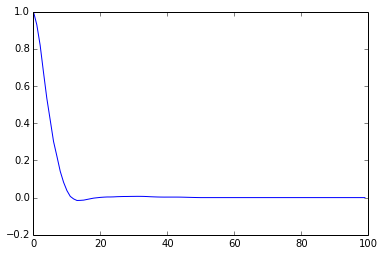

In [174]:
autocorrfn = '/Users/swolff/Disks/mcfost-python/mean_autocorr.npy'
mean_autocorr = np.load(autocorrfn)
autocorrelation = np.zeros((100.0))
autocorrelation[0:50] = mean_autocorr[49,49:]
plt.plot(autocorrelation)

In [175]:
def generate_image_covariance_matrix(observations, autocorrelation, matern=False, analytical=True, wavelength=None):

    # Get Observed Data
    im = observations.images
    mask = im[wavelength].mask
    image = im[wavelength].image
    noise = im[wavelength].uncertainty
    """
    print image.max()
    print image.min()
    print noise.max()
    print noise.min()
    """
    # Generate x and y position matrices for the covariance matrix
    xij = np.zeros(image.shape)
    yij = np.zeros(image.shape)
    for ind in np.arange(image.shape[0]):
        yij[:,ind] = np.arange(image.shape[0])
        xij[ind,:] = np.arange(image.shape[1])

    # Convert all relevant arrays to 1D matrix
    matrix_obs = image[mask != 0]
    matrix_noise = noise[mask != 0]
    xij_matrix = xij[mask != 0]
    yij_matrix = yij[mask != 0]

    # Set some parameters needed for the Matern Kernel
    l = 5.0
    ro = 4.0*l
    b = 1.0
    ag = 1.0


    # Covariance Matrix has the functional form:
    # C_ij = b * \delta_ij noise^2_i + K_ij(phi_G)
    # Construct  K_ij:
    nx = mask[mask != 0].shape[0]
    ny = nx
    xx = np.arange(nx)
    yy = np.arange(ny)
    rij = np.zeros((nx,ny))
    wij = np.zeros((nx,ny))
    sigma_diag = np.zeros((nx,ny))
    global_covariance = np.zeros((nx,ny))
    #rij = sqrt((xi-xj)**2+(yi-yj)**2)
    #cij = sigmai sigmaj wij (1+(np.sqrt(3)*rij/l))*np.exp(-np.sqrt(3)*rij/l) 
    interpolator = scipy.interpolate.interp1d(np.arange(autocorrelation.shape[0]), autocorrelation, kind='linear', copy=False)


    for i in xx: 
        for j in yy:
            if i == j:
                sigma_diag[j,i] = b*matrix_noise[i]*matrix_noise[i]
            rij[j,i] = np.sqrt((xij_matrix[i]-xij_matrix[j])**2.0+(yij_matrix[i]-yij_matrix[j])**2.0)
            if rij[j,i] <= ro:
                wij[j,i] = 0.5+0.5*np.cos(np.pi*rij[j,i]/ro)
            else:
                wij[j,i] = 0.0
            global_covariance[j,i]=ag * interpolator(rij[j,i]) * wij[j,i]  #matrix_noise[i]*matrix_noise[j]*  
            #if j==0:
            #    print interpolator(rij[j,i]), rij[j,i]

    K_global =  ag * (1+(np.sqrt(3)*rij/l))*np.exp(-np.sqrt(3)*rij/l)*wij
    
    if matern:
        covariance = sigma_diag + K_global
    if analytical:
        covariance = sigma_diag + global_covariance

       

    return covariance



In [176]:

def generate_sed_covariance_matrix(observations):

    # Get the sed and uncertainties
    obs_wavelengths = observations.sed.wavelength
    obs_nufnu = observations.sed.nu_fnu
    obs_nufnu_uncert = observations.sed.nu_fnu_uncert
    noise = obs_nufnu_uncert.value


    # Covariance Matrix has the functional form:
    # C_ij = b * \delta_ij noise^2_i + K_ij(phi_G)
    # Construct  K_ij:
    nx = noise.shape[0]
    ny = nx
    xx = np.arange(nx)
    yy = np.arange(ny)
    sigma_diag = np.zeros((nx,ny))
    b = 1.0

    for k in xx: 
        for j in yy:
            if k == j:
                sigma_diag[j,k] = b*noise[k]*noise[k]
               
    covariance = sigma_diag
    return covariance


In [177]:

# Generate the covariance matrix for the SED (plus det and inv).
covariance =  generate_sed_covariance_matrix(obs)
covariance_inv = np.linalg.inv(covariance)
(sign, logdet) = np.linalg.slogdet(covariance)
# Stack the covariance, inverse, and determinite along the third dimension
sed_covariance = np.array([covariance,covariance_inv,logdet,sign])
print sign
print logdet

1.0
-1204.1932618


In [178]:
imwavelength=0.8
# Generate the covariance matrix for the image (plus the det and inverse).
covariance =  generate_image_covariance_matrix(obs, autocorrelation, wavelength=imwavelength,matern=True,analytical=False)
#cholesky = np.linalg.cholesky(np.matrix(covariance))
#covariance_inv = np.dot(np.linalg.inv(cholesky),np.linalg.inv(np.transpose(cholesky)))
#covariance_det = np.linalg.det(covariance)
#covariance_det = (np.linalg.det(cholesky))**2.0
covariance_inv = np.linalg.inv(covariance)
(sign, logdet) = np.linalg.slogdet(covariance)
# Stack the covariance, inverse, and determinite along the third dimension
image_covariance = np.array([covariance,covariance_inv,logdet,sign])
print sign
print logdet


1.0
-9613.60170536


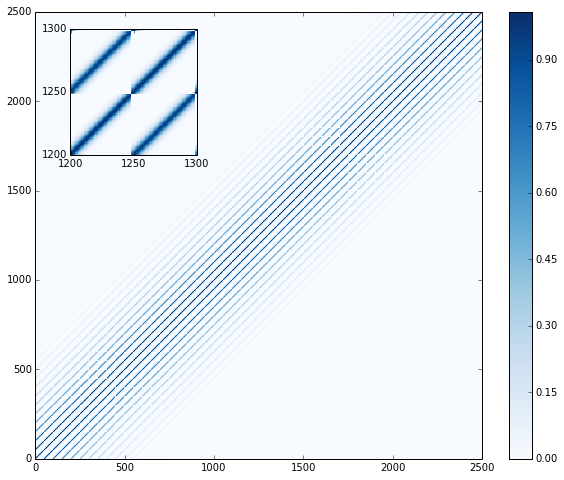

In [193]:
fig = plt.figure(figsize=(10,8))
plt.imshow(covariance,cmap='Blues',interpolation='nearest',origin='lower')
plt.colorbar()

# this is another inset axes over the main axes
a = plt.axes([0.152, 0.652, .22, .22], axisbg='y')
plt.imshow(covariance[1200:1300, 1200:1300], cmap='Blues',interpolation='nearest',origin='lower')
x = [0,50,100]
y = [0,50,100]
labels = ['1200','1250','1300']
plt.xticks(x, labels)
plt.yticks(y,labels)


plt.savefig('/Users/swolff/Disks/ESO_Halpha_569/ESOHalpha569_Paper/covariance_matrix.pdf',transparent=True, bbox_inches='tight')



INFO:mcfost:inclination 0 : 60.0 deg has loglike = -162923767.052782
INFO:mcfost:inclination 0 : 60.0 deg has chi2 =      106.181633
INFO:mcfost:inclination 1 : 62.3 deg has loglike = -87110856.167138
INFO:mcfost:inclination 1 : 62.3 deg has chi2 =      102.272360
INFO:mcfost:inclination 2 : 64.6 deg has loglike = -20064488.418298
INFO:mcfost:inclination 2 : 64.6 deg has chi2 =       93.839675
INFO:mcfost:inclination 3 : 66.9 deg has loglike = -2089612.695058
INFO:mcfost:inclination 3 : 66.9 deg has chi2 =       84.638664
INFO:mcfost:inclination 4 : 69.1 deg has loglike =  -218133.720953
INFO:mcfost:inclination 4 : 69.1 deg has chi2 =       75.987810
INFO:mcfost:inclination 5 : 71.3 deg has loglike =   -66250.673079
INFO:mcfost:inclination 5 : 71.3 deg has chi2 =       68.516525
INFO:mcfost:inclination 6 : 73.4 deg has loglike =   -27285.044702
INFO:mcfost:inclination 6 : 73.4 deg has chi2 =       61.582913
INFO:mcfost:inclination 7 : 75.5 deg has loglike =   -14172.200406
INFO:mcfost:

(-1000, 1000)

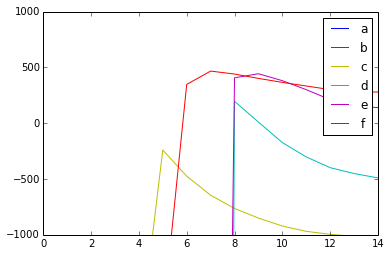

In [301]:
sedlikea = mcfost.sed_likelihood(modela, obs, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedlikeb = mcfost.sed_likelihood(modelb, obs, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedlikec = mcfost.sed_likelihood(modelc, obs, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedliked = mcfost.sed_likelihood(modeld, obs, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedlikee = mcfost.sed_likelihood(modele, obs, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedlikef = mcfost.sed_likelihood(modelf, obs, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
likelihoods = [sedlikea,sedlikeb,sedlikec,sedliked,sedlikee,sedlikef]
labels = ['a','b','c','d','e','f']
colors = ['b','g','y','c','m','r']
for i in np.arange(6):
    plt.plot(likelihoods[i],label=labels[i],color=colors[i])
plt.legend()
plt.ylim((-1000,1000))

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 1802737.111047
INFO:mcfost:inclination 0 : 60.0 deg has loglike = -277.121711
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 1842048.927124
INFO:mcfost:inclination 1 : 62.3 deg has loglike = -290.945253
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 1840669.967582
INFO:mcfost:inclination 2 : 64.6 deg has loglike = -323.714454
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 1816693.405953
INFO:mcfost:inclination 3 : 66.9 deg has loglike = -272.238092
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 1788669.272200
INFO:mcfost:inclination 4 : 69.1 deg has loglike = -219.176007
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 1751085.793966
INFO:mcfost:inclination 5 : 71.3 deg has loglike = -154.232154
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 1700084.167006
INFO:mcfost:inclination 6 : 73.4 deg has loglike = -75.930904
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 1644631.046027
INFO:mcfost:inclination 7 : 75.5 deg has loglike = -500.

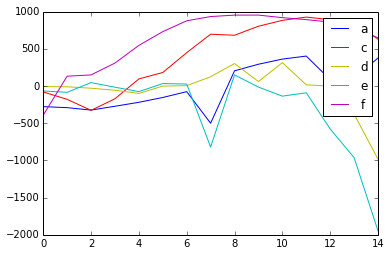

In [303]:
imlikea = mcfost.image_likelihood(modela, obs, image_covariance, wavelength=0.8)
#imlikeb = mcfost.image_likelihood(modelb, obs, image_covariance, wavelength=0.8)
imlikec = mcfost.image_likelihood(modelc, obs, image_covariance, wavelength=0.8)
imliked = mcfost.image_likelihood(modeld, obs, image_covariance, wavelength=0.8)
imlikee = mcfost.image_likelihood(modele, obs, image_covariance, wavelength=0.8)
imlikef = mcfost.image_likelihood(modelf, obs, image_covariance, wavelength=0.8)

likelihoods = [imlikea,imlikec,imliked,imlikee,imlikef]
labels = ['a','c','d','e','f']
colors = ['b','r','y','c','m']

for i in np.arange(5):
    plt.plot(likelihoods[i],label=labels[i],color=colors[i])
plt.legend()
#plt.ylim((-7000,-2000))

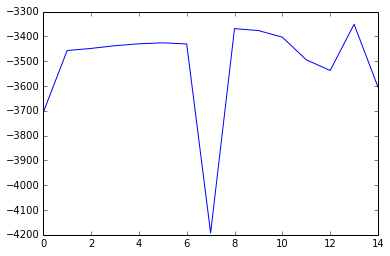

In [195]:
#fig = plt.figure(figsize=(20,20))

#nx = covariance.shape[0]
#inds = [np.ceil((nx/2.0)-50):np.ceil((nx/2.0)+50),np.ceil((nx/2.0)-50):np.ceil((nx/2.0)+50)]
#plt.imshow(covariance, 
#           interpolation='nearest', origin='lower',cmap ='Blues')
#plt.colorbar()
#plt.show()
#plt.savefig('covariance_full.pdf', Transparent=True, bbox_inches='tight')
plt.plot(covariance)

In [68]:
imagechic = mcfost.image_chisqr(modelc, obs, wavelength=0.8)

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 7.96761e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 7.57586e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 7.3877e+06
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 5.98519e+06
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 3.41656e+06
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 2.14563e+06
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 839050
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 370663
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 150835
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 87981.6
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 125290
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 289966
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 591975
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 1.08955e+06
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 1.83691e+06


In [69]:
imagechid = mcfost.image_chisqr(modeld, obs, wavelength=0.8)

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 5.36198e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 5.5466e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 5.81692e+06
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 6.0333e+06
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 6.2446e+06
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 6.08476e+06
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 4.79751e+06
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 2.4719e+06
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 1.20317e+06
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 1.076e+06
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 1.36937e+06
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 2.04385e+06
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 3.18072e+06
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 5.00768e+06
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 6.60981e+06


In [70]:
imagechie = mcfost.image_chisqr(modele, obs, wavelength=0.8)
print imagechie[0]

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 4.1731e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 4.45035e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 4.71995e+06
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 5.02828e+06
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 5.19782e+06
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 4.61541e+06
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 2.57499e+06
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 1.06413e+06
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 792184
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 972505
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 1.42573e+06
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 2.17098e+06
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 3.32274e+06
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 4.94172e+06
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 7.24704e+06


4173104.76924


In [71]:
imagechif = mcfost.image_chisqr(modelf, obs, wavelength=0.8)

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 3.93955e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 3.3752e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 2.46184e+06
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 1.32205e+06
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 475201
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 138418
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 69589.7
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 94164
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 166718
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 298020
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 471907
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 711837
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 1.034e+06
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 1.45153e+06
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 1.99324e+06


In [150]:
sedchia = mcfost.sed_chisqr(modela, obs, dof=1,vary_distance=False,vary_AV=False, AV_range=[0.0,10.0])#AV_range=np.arange(0.0,10.25,0.25))

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 3.78498e+08
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 1.7931e+08
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 4.09405e+07
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 4.23336e+06
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 443566
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 135128
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 56045
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 29519.2
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 17473.2
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 10324.8
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 7002.94
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 6053.82
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 5108.77
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 4316.15
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 3780.9


In [152]:
sedchib = mcfost.sed_chisqr(modelb,obs, dof=1,vary_distance=False,vary_AV=False,  AV_range=[0.0,10.0])#AV_range=np.arange(0.0,10.25,0.25))

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 6.00131e+07
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 6.01028e+07
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 5.948e+07
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 5.64113e+07
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 5.02807e+07
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 3.74132e+07
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 2.11948e+07
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 7.94347e+06
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 1.90416e+06
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 359111
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 113593
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 76864.9
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 65372.3
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 59355.5
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 57107.7


In [153]:
sedchic = mcfost.sed_chisqr(modelc,obs, dof=1, vary_distance=False,vary_AV=False, AV_range=[0.0,10.0])# AV_range=np.arange(0.0,10.25,0.25))

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 6.00104e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 4.93071e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 2.12504e+06
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 339218
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 5213.99
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 1654.79
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 2123.95
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 2465.11
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 2702.33
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 2875.33
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 3017.44
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 3112.75
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 3166.58
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 3202.44
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 3214.01


In [154]:
sedchid = mcfost.sed_chisqr(modeld, obs, dof=1, vary_distance=False,vary_AV=False, AV_range=[0.0,10.0])# AV_range=np.arange(0.0,10.25,0.25))
print sedchid[0]

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 3.61952e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 3.66224e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 3.68261e+06
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 3.70281e+06
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 3.55011e+06
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 2.77347e+06
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 959440
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 73835
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 808.991
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 1154.87
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 1522.37
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 1779.54
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 1971.68
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 2077.38
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 2155.28


3619518.47331


In [155]:
sedchie = mcfost.sed_chisqr(modele, obs, dof=1, vary_distance=False,vary_AV=False, AV_range=[0.0,10.0])# AV_range=np.arange(0.0,10.25,0.25))

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 1.53484e+07
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 1.55152e+07
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 1.5566e+07
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 1.54172e+07
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 1.35445e+07
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 7.45189e+06
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 1.09154e+06
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 39387.3
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 2299.63
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 1240.94
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 876.167
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 807.465
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 882.563
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 964.853
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 961.156


In [156]:
sedchif = mcfost.sed_chisqr(modelf, obs, dof=1, vary_distance=False,vary_AV=False,  AV_range=[0.0,10.0])#AV_range=np.arange(0.0,10.25,0.25))

INFO:mcfost:inclination 0 : 60.0 deg has chi2 = 2.62026e+06
INFO:mcfost:inclination 1 : 62.3 deg has chi2 = 1.55601e+06
INFO:mcfost:inclination 2 : 64.6 deg has chi2 = 647720
INFO:mcfost:inclination 3 : 66.9 deg has chi2 = 190182
INFO:mcfost:inclination 4 : 69.1 deg has chi2 = 40378.8
INFO:mcfost:inclination 5 : 71.3 deg has chi2 = 6647.62
INFO:mcfost:inclination 6 : 73.4 deg has chi2 = 1507.07
INFO:mcfost:inclination 7 : 75.5 deg has chi2 = 860.64
INFO:mcfost:inclination 8 : 77.6 deg has chi2 = 724.351
INFO:mcfost:inclination 9 : 79.7 deg has chi2 = 655.146
INFO:mcfost:inclination 10 : 81.8 deg has chi2 = 629.208
INFO:mcfost:inclination 11 : 83.8 deg has chi2 = 638.437
INFO:mcfost:inclination 12 : 85.9 deg has chi2 = 692.53
INFO:mcfost:inclination 13 : 88.0 deg has chi2 = 702.54
INFO:mcfost:inclination 14 : 90.0 deg has chi2 = 696.272


In [157]:
print sedchia, sedchib, sedchic, sedchid, sedchie, sedchif

[  3.78497666e+08   1.79309955e+08   4.09404777e+07   4.23335778e+06
   4.43565710e+05   1.35128207e+05   5.60450343e+04   2.95191880e+04
   1.74732043e+04   1.03248064e+04   7.00293617e+03   6.05381983e+03
   5.10876735e+03   4.31615330e+03   3.78090014e+03] [  6.00130861e+07   6.01028385e+07   5.94800218e+07   5.64112878e+07
   5.02807220e+07   3.74132161e+07   2.11947724e+07   7.94346589e+06
   1.90416215e+06   3.59111199e+05   1.13592760e+05   7.68648853e+04
   6.53723417e+04   5.93554709e+04   5.71076903e+04] [  6.00103782e+06   4.93071201e+06   2.12504295e+06   3.39218498e+05
   5.21399180e+03   1.65479451e+03   2.12394894e+03   2.46511106e+03
   2.70232571e+03   2.87532627e+03   3.01743841e+03   3.11274989e+03
   3.16658497e+03   3.20243777e+03   3.21400798e+03] [  3.61951847e+06   3.66224026e+06   3.68260507e+06   3.70281038e+06
   3.55011395e+06   2.77347043e+06   9.59439669e+05   7.38349982e+04
   8.08990506e+02   1.15487012e+03   1.52236750e+03   1.77953520e+03
   1.97168240

In [158]:
x = np.arange(60.0, 90.0, 2.0)

In [159]:
import astropy.io.fits as fits

f = fits.open(modelsdir+"esoha569_6603/observables/sed_chisq.fits") 
idlres = f[1].data[0]
ya = idlres[1]
print idlres

f = fits.open(modelsdir+"esoha569_16446/observables/sed_chisq.fits") 
idlres = f[1].data[0]
yb = idlres[1]

f = fits.open(modelsdir+"esoha569_26537/observables/sed_chisq.fits") 
idlres = f[1].data[0]
yc = idlres[1]

f = fits.open(modelsdir+"esoha569_27480/observables/sed_chisq.fits") 
idlres = f[1].data[0]
yd = idlres[1]

f = fits.open(modelsdir+"esoha569_27540/observables/sed_chisq.fits") 
idlres = f[1].data[0]
ye = idlres[1]

f = fits.open(modelsdir+"esoha569_28417/observables/sed_chisq.fits") 
idlres = f[1].data[0]
yf = idlres[1]

(array([  8.10961151,  14.06986141,  18.19487572,  21.56518555,
        24.49465561,  27.12675667,  29.54136276,  31.78833008,
        33.90126801,  35.90406799,  37.81448746,  39.64611435,
        41.40962219,  43.11360931,  44.76508331,  46.36989212,
        47.93294144,  49.45840073,  50.94988251,  52.41049957,
        53.84299088,  55.24977875,  56.63298798,  57.99455261,
        59.3361702 ,  60.6594162 ,  61.96570206,  63.25631714,
        64.53244019,  65.79516602,  67.04550171,  68.28437805,
        69.51268768,  70.73122406,  71.94077301,  73.14204407,
        74.33573914,  75.52249146,  76.70293427,  77.8776474 ,
        79.04721832,  80.21218109,  81.37308502,  82.53041077,
        83.68469238,  84.83639526,  85.98601532,  87.13402557,
        88.28087616,  89.42703247], dtype=float32), array([  5.37292560e+07,   2.55091640e+07,   5.83644400e+06,
         6.03843438e+05,   6.32728789e+04,   1.92742598e+04,
         7.99351562e+03,   4.20998193e+03,   2.49190405e+03,
        

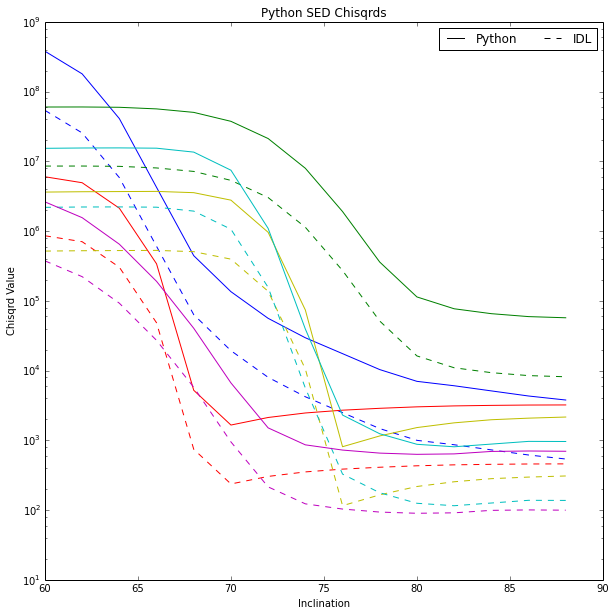

In [161]:
fig = plt.figure(figsize=(10,10))

plt.plot(x, sedchia,'b')#,label='Py 6603')
plt.plot(x,ya,'b--')#,label='IDL 6603')
plt.yscale("log")
plt.plot(x,sedchib,'g')#, label='Py 16446')
plt.plot(x,yb,'g--')#,label='IDL 28417')
plt.plot(x,sedchic,'r')#, label='Py 26537')
plt.plot(x,yc,'r--')#,label='IDL 28417')
plt.plot(x,sedchid,'y')#, label='Py 27480')
plt.plot(x,yd,'y--')#,label='IDL 28417')
plt.plot(x,sedchie,'c')#, label='Py 27540')
plt.plot(x,ye,'c--')#,label='IDL 28417')
plt.plot(x,sedchif,'m')#, label='Py 28417')
plt.plot(x,yf,'m--')#,label='IDL 28417')
plt.plot([75,75],[-1,-1],'k',label='Python')
plt.plot([75,75],[-1,-1],'k--',label='IDL')

plt.xlabel('Inclination')
plt.ylabel('Chisqrd Value')
plt.title('Python SED Chisqrds')
plt.legend(ncol=2,loc=1)
#plt.ylim((1,200))
plt.show()

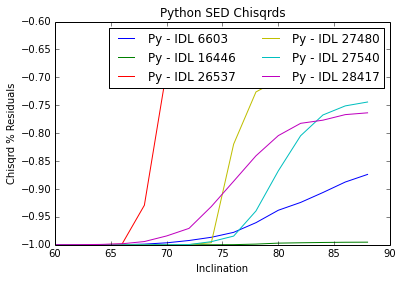

In [82]:
plt.plot(x,(sedchia-ya)/ya,'b', label='Py - IDL 6603')
plt.plot(x,(sedchib-yb)/yb,'g', label='Py - IDL 16446')
plt.plot(x,(sedchic-yc)/yc,'r', label='Py - IDL 26537')
plt.plot(x,(sedchid-yd)/yd,'y', label='Py - IDL 27480')
plt.plot(x,(sedchie-ye)/ye,'c', label='Py - IDL 27540')
plt.plot(x,(sedchif-yf)/yf,'m', label='Py - IDL 28417')
plt.xlabel('Inclination')
plt.ylabel('Chisqrd % Residuals')
plt.title('Python SED Chisqrds')
plt.legend(ncol=2,loc=1)
plt.show()


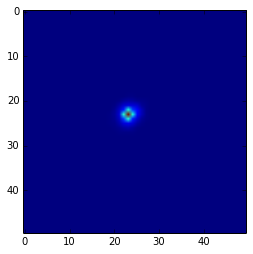

In [83]:
im = obs.images
mask = im[0.8].mask
image = im[0.8].image
noise = im[0.8].uncertainty
psf = im[0.8].psf
plt.imshow(psf)



plt.show()

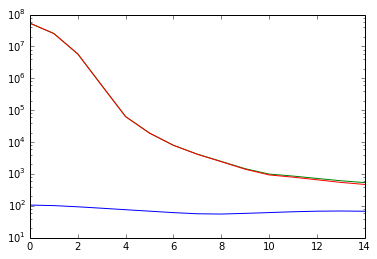

In [84]:
difference = ya-sedchia
plt.plot(sedchia)
plt.plot(ya)
plt.plot(difference)
plt.yscale("log")
plt.show()

In [85]:
f = fits.open(modelsdir+"idl_results/chi2_6603.idl.fits")
imiya = f[0].data[0]
print imiya

f = fits.open(modelsdir+"idl_results/chi2_26537.idl.fits")
imiyc = f[0].data[0]

f = fits.open(modelsdir+"idl_results/chi2_27480.idl.fits")
imiyd = f[0].data[0]

f = fits.open(modelsdir+"idl_results/chi2_27540.idl.fits")
imiye = f[0].data[0]

f = fits.open(modelsdir+"idl_results/chi2_28417.idl.fits")
imiyf = f[0].data[0]

[  9670012.99396732  10881245.35737438  10698021.29228486
   9423151.36005077   8191858.16554043   6899887.76899157
   5612130.75700654   4538215.49993738   3611468.15339785
   2952483.17283477   2556698.98316936   2393837.71509683
   2352311.33047127   2257817.87426709   1935244.38416828]


In [86]:
f = fits.open(modelsdir+"yorick_results/image_0.8_chi2_6603.fits.gz")
imya = f[0].data

f = fits.open(modelsdir+"yorick_results/image_0.8_chi2_26537.fits.gz")
imyc = f[0].data

f = fits.open(modelsdir+"yorick_results/image_0.8_chi2_27480.fits.gz")
imyd = f[0].data

f = fits.open(modelsdir+"yorick_results/image_0.8_chi2_27540.fits.gz")
imye = f[0].data

f = fits.open(modelsdir+"yorick_results/image_0.8_chi2_28417.fits.gz")
imyf = f[0].data

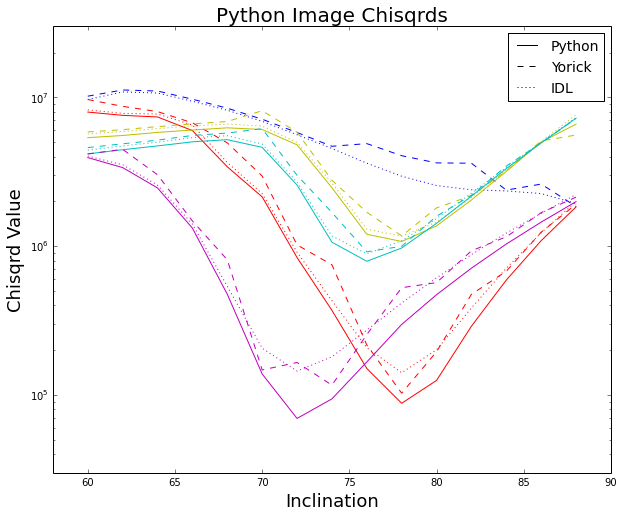

In [168]:
fig = plt.figure(figsize=(10,8))
fsz = 18
#plt.plot(x, imagechia,'b',label='Py 6603')
plt.plot(x,imya,'b--')#,label='Yor 6603')
plt.plot(x,imiya,'b:')#,label='IDL 6603')
plt.yscale("log")
#plt.plot(x,imagechib,'g', label='Py 16446')
#plt.plot(x,yb,'g--',label='IDL 28417')
plt.plot(x,imagechic,'r')#label='Py 26537')
plt.plot([50.0,50.0],[-200,-100],'k',label='Python')
plt.plot([50.0,50.0],[-200,-100],'k--',label='Yorick')
plt.plot([50.0,50.0],[-200,-100],'k:',label='IDL')

plt.plot(x,imyc,'r--')#label='Yor 26537')
plt.plot(x,imiyc,'r:')#label='IDL 26537')
plt.plot(x,imagechid,'y')#, label='Py 27480')
plt.plot(x,imyd,'y--')#,label='Yor 27480')
plt.plot(x,imiyd,'y:')#,label='IDL 27480')
plt.plot(x,imagechie,'c')#, label='Py 27540')
plt.plot(x,imye,'c--')#,label='Yor 27540')
plt.plot(x,imiye,'c:')#,label='IDL 27540')
plt.plot(x,imagechif,'m')#, label='Py 28417')
plt.plot(x,imyf,'m--')#,label='Yor 28417')
plt.plot(x,imiyf,'m:')#,label='IDL 28417')
plt.xlim((58,90))
plt.ylim((3e4,3e7))
plt.xlabel('Inclination',fontsize=fsz)
plt.ylabel('Chisqrd Value',fontsize=fsz)
plt.title('Python Image Chisqrds', fontsize=fsz+2)
plt.legend(ncol=1, prop={'size':14})

plt.savefig('/Users/swolff/Disks/ESO_Halpha_569/ESOHalpha569_Paper/image_benchmarks.pdf',transparent=True, bbox_inches='tight')
plt.show()

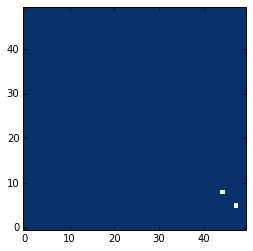

1362.97560972
1362.97560972
2.4375 6.9375


In [165]:
im = obs.images
mask = im[0.8].mask
psf = im[0.8].psf
image = im[0.8].image
image = np.multiply(image,mask)
model = modela.images[0.8].data
model = np.asarray(model[0,0,0,:,:])

model = image_registration.fft_tools.convolve_nd.convolvend(model,psf)
weightgd=image.sum()/model.sum()
model=model*weightgd
dy,dx,xerr,yerr = image_registration.chi2_shifts.chi2_shift_iterzoom(model,image)

plt.imshow(mask, origin='lower',interpolation='nearest',cmap='Blues')
plt.show()
print model.sum()
print image.sum()
#plt.imshow(image)
#plt.imshow(model)
print dy,dx

nonnoise model:
[  9.95173011e-05   2.26971272e-04   4.02427095e-04   5.02501011e-04
   5.74336992e-04   5.45154998e-04   5.00867844e-04   4.53095418e-04
   4.74912434e-04   5.65185090e-04   4.98059647e-04   2.30603142e-04
   6.53042409e-04   1.09237545e-03   4.35681347e-02   4.56045919e-02] Jy
1 sigma model:
[  9.94958317e-05   2.39957573e-04   4.14569242e-04   5.09638410e-04
   5.75842867e-04   5.40430026e-04   5.05751518e-04   4.60088149e-04
   4.64947087e-04   5.47815598e-04   4.93202847e-04   2.41567564e-04
   6.62305531e-04   1.09004338e-03   4.35816689e-02   4.56062964e-02] Jy [ -2.14693567e-08   1.29863003e-05   1.21421474e-05   7.13739896e-06
   1.50587472e-06  -4.72497139e-06   4.88367440e-06   6.99273147e-06
  -9.96534712e-06  -1.73694920e-05  -4.85680029e-06   1.09644224e-05
   9.26312210e-06  -2.33207235e-06   1.35342479e-05   1.70446086e-06] Jy
5 sigma model:
[  8.93722629e-05   2.00660582e-04   3.83012062e-04   4.45746640e-04
   5.76133605e-04   5.71116898e-04   5.184535

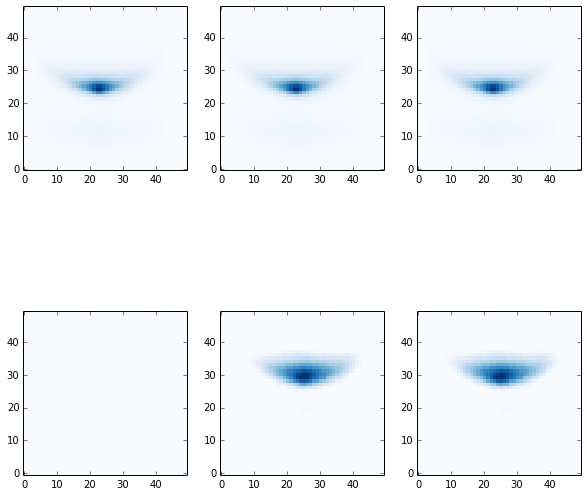

In [101]:
# Generate fake datasets from a model image for no noise, 1 sigma, and 5 sigma cases
# These will be used to test the likelihood model generation functions. 


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))

model_ex = mcfost.ModelResults('/Users/swolff/Disks/ESO_Halpha_569/results/emcee_best_fit_models/71.57_25.63_0.0004936_1.543_-1.757/')

# Read in the model
#modele.describe()
model = model_ex.images[0.8].data
n=10
model_n = np.asarray(model[0,0,0,:,:])
model_n = np.asarray(image_registration.fft_tools.convolve_nd.convolvend(model_n,psf))
model_n*=1.0e19
axes[0, 0].imshow(model_n,interpolation='nearest',origin='lower',cmap='Blues')

############## SED ##############
mod_nufnu = modelf.sed.nu_fnu
mod_wavelengths = modelf.sed.wavelength
obs_wavelengths = obs.sed.wavelength
frequency = (2.99e8/obs_wavelengths*(units.m)/(units.s)).to(units.Hz)
#print frequency
interpolator = scipy.interpolate.interp1d(mod_wavelengths, mod_nufnu[n], kind='linear', copy=False)
est_mod_nufnu = interpolator(obs_wavelengths)*(units.W/units.m**2)
#print est_mod_nufnu
fluxmjy = (est_mod_nufnu/frequency).to(units.Jy)

print 'nonnoise model:'
print fluxmjy

modelmean = fluxmjy.min()
mu, sigma = 0, 0.1 # mean and standard deviation
noise = modelmean*np.random.normal(mu, sigma, 16)

print '1 sigma model:'
print fluxmjy+noise, noise

mu, sigma = 0, 0.5 # mean and standard deviation
noise = modelmean*np.random.normal(mu, sigma, 16)

print '5 sigma model:'
print fluxmjy+noise, noise


##################################################
############ Generate No Noise data ##############
##################################################
imagefn = modelsdir+'data/jbpj16021_drc_65.fits'
hdulist = fits.open(imagefn)
#hdulist.info()
scidata = hdulist['SCI'].data

hdulist['SCI'].data = model_n

hdulist.writeto('/Users/swolff/Disks/mcfost-python/standard_tests/nonoise_data/nonoise_image.fits',clobber=True)
hdulist.close()

noisefn = modelsdir+'data/jbpj16021_drc_noise_lowlimit.fits'
hdulist = fits.open(noisefn)

mu, sigma = 0, 0.0001 # mean and standard deviation
noise = modelmax*np.random.normal(mu, sigma, 2500).reshape(50,50)
nonoisedata = model_n+noise
#noisedata = hdulist[0].data
hdulist[0].data = nonoisedata
print noisedata.shape
axes[1,0].imshow(noisedata,interpolation='nearest',origin='lower',cmap='Blues')

noisedata[:,:] = 1.0e-10
hdulist.writeto('/Users/swolff/Disks/mcfost-python/standard_tests/nonoise_data/nonoise_noise.fits',clobber=True)
hdulist.close()



##################################################
############# Generate 1 Sigma data ##############
##################################################


noisefn = modelsdir+'data/jbpj16021_drc_noise_lowlimit.fits'
hdulist = fits.open(noisefn)
noisedata = hdulist[0].data
print noisedata.shape
#noisedata[:,:] = noise
#hdulist[0].data = noisedata
axes[1,1].imshow(noisedata,interpolation='nearest',origin='lower',cmap='Blues')

hdulist.writeto('/Users/swolff/Disks/mcfost-python/standard_tests/onesigma_data/onesigma_noise.fits',clobber=True)
hdulist.close()

imagefn = modelsdir+'data/jbpj16021_drc_65.fits'
hdulist = fits.open(imagefn)
hdulist.info()
scidata = hdulist['SCI'].data
print scidata.shape
modelmax = model_n.mean()
mu, sigma = 0, 0.1 # mean and standard deviation
noise = modelmax*np.random.normal(mu, sigma, 2500).reshape(50,50)
hdulist['SCI'].data = model_n+noisedata
axes[0, 1].imshow(model_n+noisedata,interpolation='nearest',origin='lower',cmap='Blues')

hdulist.writeto('/Users/swolff/Disks/mcfost-python/standard_tests/onesigma_data/onesigma_image.fits',clobber=True)
hdulist.close()

##################################################
############# Generate 5 Sigma data ##############
##################################################

noisefn = modelsdir+'data/jbpj16021_drc_noise_lowlimit.fits'
hdulist = fits.open(noisefn)
noisedata = hdulist[0].data
#print noisedata.shape
#noisedata[:,:] = noise
#hdulist[0].data = noise
hdulist[0].data = noisedata*5.0
axes[1,2].imshow(noisedata,interpolation='nearest',origin='lower',cmap='Blues')


hdulist.writeto('/Users/swolff/Disks/mcfost-python/standard_tests/fivesigma_data/fivesigma_noise.fits',clobber=True)
hdulist.close()

imagefn = modelsdir+'data/jbpj16021_drc_65.fits'
hdulist = fits.open(imagefn)
hdulist.info()
scidata = hdulist['SCI'].data
print scidata.shape
modelmax = model_n.mean()
mu, sigma = 0, 0.5 # mean and standard deviation
noise = modelmax*np.random.normal(mu, sigma, 2500).reshape(50,50)
hdulist['SCI'].data = model_n+noisedata*5.0
axes[0, 2].imshow(model_n+noisedata*5.0,interpolation='nearest',origin='lower',cmap='Blues')

hdulist.writeto('/Users/swolff/Disks/mcfost-python/standard_tests/fivesigma_data/fivesigma_image.fits',clobber=True)
hdulist.close()




INFO:mcfost:Found observations: observed_sed.txt is SED
INFO:mcfost:Found observations: onesigma_image.fits is image at 0.8
INFO:mcfost:Found observations: hst_psf_814.fits is psf at 0.8
INFO:mcfost:Found observations: onesigma_noise.fits is IMAGE_UNCERT at 0.8
INFO:mcfost:Found observations: jbpj16021_drc_mask.fits is mask at 0.8
INFO:mcfost:Found observations: observed_sed.txt is SED
INFO:mcfost:Found observations: nonoise_image.fits is image at 0.8
INFO:mcfost:Found observations: hst_psf_814.fits is psf at 0.8
INFO:mcfost:Found observations: nonoise_noise.fits is IMAGE_UNCERT at 0.8
INFO:mcfost:Found observations: jbpj16021_drc_mask.fits is mask at 0.8
INFO:mcfost:Found observations: observed_sed.txt is SED
INFO:mcfost:Found observations: fivesigma_image.fits is image at 0.8
INFO:mcfost:Found observations: hst_psf_814.fits is psf at 0.8
INFO:mcfost:Found observations: fivesigma_noise.fits is IMAGE_UNCERT at 0.8
INFO:mcfost:Found observations: jbpj16021_drc_mask.fits is mask at 0.8


(1257, 1257)
Model results in /Users/swolff/Disks/ESO_Halpha_569/results/emcee_best_fit_models/71.57_25.63_0.0004936_1.543_-1.757 for 71.57_25.63_0.0004936_1.543_-1.757.para
    Model has 1 inclinations from 71.6 to 71.6
    SED computed from 0.1 - 3500.0 microns using 30 wavelengths
    Images computed for 1 wavelengths: [ 0.8] micron


<matplotlib.colorbar.Colorbar instance at 0x1100beb00>

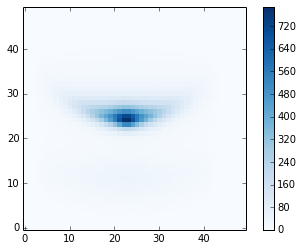

In [162]:
standarddir = '/Users/swolff/Disks/mcfost-python/standard_tests/'
onesigmadata = mcfost.Observations(standarddir+'onesigma_data')
nonoisedata = mcfost.Observations(standarddir+'nonoise_data')
fivesigmadata = mcfost.Observations(standarddir+'fivesigma_data')

nonoise_covariance =  generate_image_covariance_matrix(nonoisedata, autocorrelation, wavelength=imwavelength,matern=True,analytical=False)
onesigma_covariance = generate_image_covariance_matrix(onesigmadata, autocorrelation, wavelength=imwavelength,matern=True,analytical=False)
fivesigma_covariance = generate_image_covariance_matrix(fivesigmadata, autocorrelation, wavelength=imwavelength,matern=True,analytical=False)

nonoise_covariance_inv = np.linalg.inv(nonoise_covariance)
(sign, logdet) = np.linalg.slogdet(nonoise_covariance)
nonoise_image_covariance = np.array([nonoise_covariance,nonoise_covariance_inv,logdet,sign])
onesigma_covariance_inv = np.linalg.inv(onesigma_covariance)
(sign, logdet) = np.linalg.slogdet(onesigma_covariance)
onesigma_image_covariance = np.array([onesigma_covariance,onesigma_covariance_inv,logdet,sign])
fivesigma_covariance_inv = np.linalg.inv(fivesigma_covariance)
(sign, logdet) = np.linalg.slogdet(fivesigma_covariance)
fivesigma_image_covariance = np.array([fivesigma_covariance,fivesigma_covariance_inv,logdet,sign])

print onesigma_covariance.shape
#model = mcfost.ModelResults(standarddir+'example_model')
model = mcfost.ModelResults('/Users/swolff/Disks/ESO_Halpha_569/results/emcee_best_fit_models/71.57_25.63_0.0004936_1.543_-1.757/')

model.describe()

im = fivesigmadata.images

image = im[0.8].image
plt.imshow(image,interpolation='nearest',origin='lower',cmap='Blues')
plt.colorbar()


INFO:mcfost:inclination 0 : 60.0 deg has loglike =  -453519.149329
INFO:mcfost:inclination 0 : 60.0 deg has chi2 =       73.673687
INFO:mcfost:inclination 1 : 62.3 deg has loglike =  -319655.838531
INFO:mcfost:inclination 1 : 62.3 deg has chi2 =       71.872211
INFO:mcfost:inclination 2 : 64.6 deg has loglike =  -176987.908635
INFO:mcfost:inclination 2 : 64.6 deg has chi2 =       68.205195
INFO:mcfost:inclination 3 : 66.9 deg has loglike =   -73840.539850
INFO:mcfost:inclination 3 : 66.9 deg has chi2 =       62.942244
INFO:mcfost:inclination 4 : 69.1 deg has loglike =   -18644.360945
INFO:mcfost:inclination 4 : 69.1 deg has chi2 =       52.267463
INFO:mcfost:inclination 5 : 71.3 deg has loglike =    -2568.102193
INFO:mcfost:inclination 5 : 71.3 deg has chi2 =       35.328088
INFO:mcfost:inclination 6 : 73.4 deg has loglike =      173.365427
INFO:mcfost:inclination 6 : 73.4 deg has chi2 =       18.934875
INFO:mcfost:inclination 7 : 75.5 deg has loglike =      501.445591
INFO:mcfost:incl

[ -4.53519149e+05  -3.19655839e+05  -1.76987909e+05  -7.38405398e+04
  -1.86443609e+04  -2.56810219e+03   1.73365427e+02   5.01445591e+02
   5.63938453e+02   5.84467815e+02   5.87256234e+02   5.81357599e+02
   5.72957226e+02   5.61181652e+02   5.58592471e+02] [ -4.53559963e+05  -3.19673141e+05  -1.76979809e+05  -7.36116172e+04
  -1.86003208e+04  -2.55836123e+03   1.77427601e+02   5.03669842e+02
   5.64966094e+02   5.84816347e+02   5.86853058e+02   5.82740766e+02
   5.74724831e+02   5.64725663e+02   5.62977698e+02] [ -4.53593858e+05  -3.19510760e+05  -1.76639297e+05  -7.21893435e+04
  -1.79366857e+04  -2.48747056e+03   1.39549883e+02   4.92798371e+02
   5.68382533e+02   5.80200138e+02   5.58712794e+02   5.34633730e+02
   5.27420305e+02   5.28667586e+02   5.31361037e+02]


(400, 800)

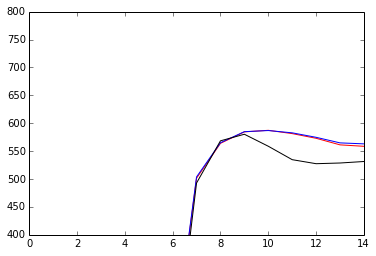

In [103]:
model = mcfost.ModelResults('/Users/swolff/Disks/ESO_Halpha_569/results/emcee_best_fit_models/71.57_25.63_0.0004936_1.543_-1.757/')
model = mcfost.ModelResults(standarddir+'example_model')

sedchinonoise = mcfost.sed_likelihood(model, nonoisedata, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedchionesigma = mcfost.sed_likelihood(model, onesigmadata, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
sedchifivesigma = mcfost.sed_likelihood(model, fivesigmadata, sed_covariance, dof=1, write=True, save=False, vary_distance=False,vary_AV=True, AV_range=[0.0,10.0])
print sedchinonoise,sedchionesigma,sedchifivesigma
plt.plot(sedchinonoise,'r')
plt.plot(sedchionesigma,'b')
plt.plot(sedchifivesigma,'k')

plt.ylim((400,800))

INFO:mcfost:inclination 0 : 71.6 deg has chi2 = 0.000000
INFO:mcfost:inclination 0 : 71.6 deg has loglike = -4437.676763
INFO:mcfost:inclination 0 : 71.6 deg has chi2 = 87191.988968
INFO:mcfost:inclination 0 : 71.6 deg has loglike = 1176.523208
INFO:mcfost:inclination 0 : 71.6 deg has chi2 = 28500.662876
INFO:mcfost:inclination 0 : 71.6 deg has loglike = 558.126257


[ 558.12625748]
[ 1176.52320762]
[-4437.67676268]


"\nplt.plot(residuala[0],'r')\nplt.plot(residualb[0],'b')\nplt.plot(residualc[0],'k')\n"

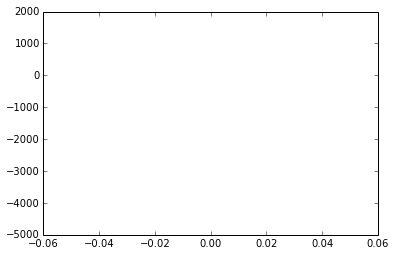

In [163]:
model = mcfost.ModelResults('/Users/swolff/Disks/ESO_Halpha_569/results/emcee_best_fit_models/71.57_25.63_0.0004936_1.543_-1.757/')

imagechinonoise= mcfost.image_likelihood(model, nonoisedata, nonoise_image_covariance, wavelength=0.8)
imagechionesigma = mcfost.image_likelihood(model, onesigmadata, onesigma_image_covariance, wavelength=0.8)
imagechifivesigma = mcfost.image_likelihood(model, fivesigmadata, fivesigma_image_covariance, wavelength=0.8)
print imagechifivesigma
print imagechionesigma
print imagechinonoise
plt.plot(imagechinonoise,'r-')
plt.plot(imagechionesigma,'b-')
plt.plot(imagechifivesigma,'k-')
#plt.ylim((-1250,-1240))
#plt.xlim((6.9,7.1))
"""
plt.plot(residuala[0],'r')
plt.plot(residualb[0],'b')
plt.plot(residualc[0],'k')
"""